In [155]:
import pandas as pd
import numpy as np

In [156]:
terms = pd.read_excel('../data/raw/terminal_data_hackathon v4.xlsx')
terms

,TID,longitude,latitude
0,692835,37.646257,55.742062
1,698656,37.666136,55.731231
2,686168,37.675027,55.727031
3,679671,37.669706,55.706824
4,682180,37.596399,55.711151
...,...,...,...
1625,607749,37.138157,56.757843
1626,699046,35.647877,56.226824
1627,637512,35.515147,56.032402
1628,680602,36.543716,55.380772


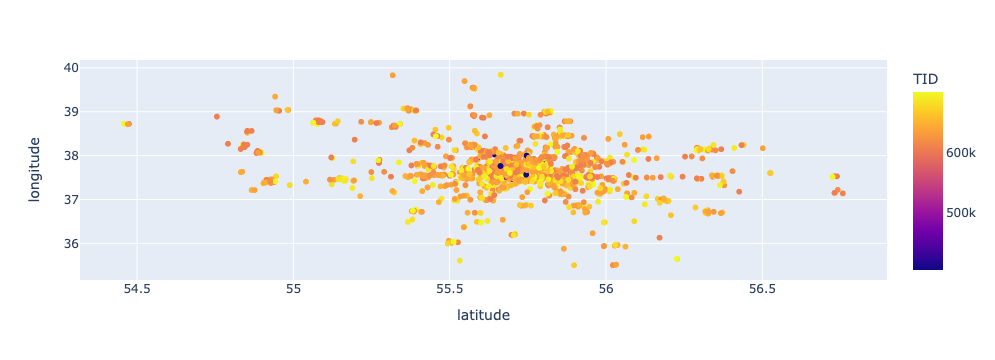

In [157]:
px.scatter(terms, x='latitude', y='longitude', color='TID')

In [158]:
data = pd.read_excel('../data/raw/terminal_data_hackathon v4.xlsx', 'Incomes')
data.head()

,TID,остаток на 31.08.2022 (входящий),2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
0,406136,160000,90000,105000,99000,107000,110000,60000,75000,89000,...,91000,78000,0,165000,0,189000,106000,94000,75000,74000
1,406139,387000,103000,206000,168000,124000,78000,165000,164000,174000,...,164000,153000,151000,157000,206000,182000,123000,138000,112000,179000
2,406145,287000,143000,136000,124000,117000,123000,140000,139000,138000,...,119000,100000,179000,169000,118000,118000,114000,128000,121000,124000
3,406148,355000,50000,73000,53000,65000,75000,100000,53000,52000,...,48000,55000,65000,85000,95000,68000,62000,0,118000,70000
4,406180,597000,96000,82000,71000,72000,86000,55000,55000,75000,...,82000,56000,70000,59000,105000,70000,77000,87000,59000,55000


In [159]:
df_unpivot = pd.melt(data, id_vars='TID', value_vars=data.columns[2:])
data = df_unpivot.sort_values(by=['TID', 'variable'])
data = data.rename(columns={'TID': 'tid', 'variable': 'date', 'value': 'income'})
data['date'] = pd.to_datetime(data['date'])
data.head()

,tid,date,income
0,406136,2022-09-01,90000
1630,406136,2022-09-02,105000
3260,406136,2022-09-03,99000
4890,406136,2022-09-04,107000
6520,406136,2022-09-05,110000


In [160]:
data['train_or_test'] = np.where(data['date'] >= '2022-11-01', 'val', 'train')
data['train_or_test'].value_counts()

train    99430
val      48900
Name: train_or_test, dtype: int64

## Get time features

In [161]:
# попробовать обучать окном (вплоть до даты предсказания) +
# подгрузить погоду 
# lightGbm
# подумать как привести задачу к решению одной vrp
# посмотреть vrp на масках (или другой быстрый vrp)
# написать ментору +

In [162]:
# !pip install --upgrade holidays holidays-ru

In [163]:
import holidays

In [164]:
ru_holidays = holidays.RU()
data['is_holiday'] = data['date'].apply(lambda x: x in ru_holidays)
data['is_holiday'].sum()

1630

In [165]:
data['dayofmonth'] = data.date.dt.day
# df['dayofyear'] = df.date.dt.dayofyear
data['dayofweek'] = data.date.dt.dayofweek
data['month'] = data.date.dt.month
# data['year'] = data.date.dt.year
# df['weekofyear'] = df.date.dt.weekofyear
data['is_month_start'] = (data.date.dt.is_month_start).astype(int)
data['is_month_end'] = (data.date.dt.is_month_end).astype(int)
data.head()

,tid,date,income,train_or_test,is_holiday,dayofmonth,dayofweek,month,is_month_start,is_month_end
0,406136,2022-09-01,90000,train,False,1,3,9,1,0
1630,406136,2022-09-02,105000,train,False,2,4,9,0,0
3260,406136,2022-09-03,99000,train,False,3,5,9,0,0
4890,406136,2022-09-04,107000,train,False,4,6,9,0,0
6520,406136,2022-09-05,110000,train,False,5,0,9,0,0


## Get mean/lags

In [166]:
# Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1, size=(len(df),)) * 0
    return df

# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1, size=(len(df),)) * 0
    return df

# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1, size=(len(df),)) * 0
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [167]:
# Converting sales of validation period to nan so as to resemble test period
train = data.copy()
y_val = train.loc[train.train_or_test=='val', 'income'].values.reshape((-1))
y_train = train.loc[train.train_or_test=='train', 'income'].values.reshape((-1))
train.loc[train.train_or_test=='val', 'income'] = np.nan

# # Creating sales lag, rolling mean, rolling median, ohe features of the above train set
train = create_sales_lag_feats(train, gpby_cols=['tid'], target_col='income', 
                               lags=[1, 7, 14, 28])

train = create_sales_rmean_feats(train, gpby_cols=['tid'], 
                                 target_col='income', windows=[1, 3, 7, 14, 28], 
                                 min_periods=1, win_type='triang')

train = create_sales_rmed_feats(train, gpby_cols=['tid'], 
                                 target_col='income', windows=[2, 3, 7, 14, 28], 
                                 min_periods=2, win_type=None)

train = create_sales_ewm_feats(train, gpby_cols=['tid'], 
                               target_col='income', 
                               alpha=[0.9, 0.7, 0.6], 
                               shift=[3, 7, 14, 28])


tid_mean = train[train.train_or_test=='train'].groupby('tid')['income'].mean().reset_index().rename(columns={'income': 'tid_mean_income'})
train = train.merge(tid_mean, on='tid', how='left')

# One-Hot Encoding 
# train = one_hot_encoder(train, ohe_cols=['store', 'item', 'month']) 
#,'dayofmonth','weekofyear'

# Final train and val datasets

Train shape:(99430, 35), Val shape:(48900, 35)


In [168]:
X_train.head()

,tid,date,is_holiday,dayofmonth,dayofweek,month,is_month_start,is_month_end,income_lag_1,income_lag_7,...,income_lag_28_ewm_0.9,income_lag_3_ewm_0.7,income_lag_7_ewm_0.7,income_lag_14_ewm_0.7,income_lag_28_ewm_0.7,income_lag_3_ewm_0.6,income_lag_7_ewm_0.6,income_lag_14_ewm_0.6,income_lag_28_ewm_0.6,tid_mean_income
0,406136,2022-09-01,False,1,3,9,1,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93770.491803
1,406136,2022-09-02,False,2,4,9,0,0,90000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93770.491803
2,406136,2022-09-03,False,3,5,9,0,0,105000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93770.491803
3,406136,2022-09-04,False,4,6,9,0,0,99000.0,NaN,...,NaN,90000.000000,NaN,NaN,NaN,90000.000000,NaN,NaN,NaN,93770.491803
4,406136,2022-09-05,False,5,0,9,0,0,107000.0,NaN,...,NaN,101538.461538,NaN,NaN,NaN,100714.285714,NaN,NaN,NaN,93770.491803


In [169]:
y_val

array([ 73000,  84000, 125000, ...,      0,  55000,      0])

## Парсим погоду

In [200]:
import requests
from bs4 import BeautifulSoup

In [201]:
url = 'http://weatherarchive.ru/Temperature/Moscow/{month}-{year}'
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

years = [2022]

In [202]:
url.format(month=months[0], year=2022)

'http://weatherarchive.ru/Temperature/Moscow/January-2022'

In [203]:
def parse_table(table):
    res = {'temp': [],
           'wet': [],
           'p': [],
           'wind': []}
    
    tags = table.findAll('td')
    k = 0
    for tag in tags:
        if tag.find('a') is not None:
            continue
            
        if k == 0:
            k += 1
            res['temp'].append(float(tag.text.replace('°C', '').replace('+','').replace('−','-')))
        elif k == 1:
            k += 1
            res['wet'].append(float(tag.text.replace('%','')))
        elif k == 2:
            k += 1
            res['p'].append(int(tag.text))
        else:
            k = 0
            res['wind'].append(int(tag.text.replace(' м/с', '')))
    return res

In [204]:
def parse_url(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")

    tables = soup.findAll('table', class_='smart')
    for table in tables:
        if 'Среднесуточная' in str(table):
            return parse_table(table)

In [205]:
pd.DataFrame(parse_url(url.format(month=months[0], year=years[0]))).head()

,temp,wet,p,wind
0,-3.90,92.25,737,3
1,-7.80,82.25,744,4
2,-9.44,87.25,739,3
3,-9.28,87.75,739,2
4,-7.40,90.13,734,4


In [206]:
stats = {}
for year in years:
    stats[year] = {}
    for month in tqdm(months):
        stats[year][month] = parse_url(url.format(month=month, year=year))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.37it/s]


In [221]:
weather = []
for i, (month, v) in enumerate(stats[2022].items()):
    i = i + 1
    for j, (temp, wet, p, wind) in enumerate(zip(v['temp'], v['wet'], v['p'], v['wind'])):
        j = j + 1
        si = '0' + str(i) if i < 10 else str(i)
        sj = '0' + str(j) if j < 10 else str(j)
        
        weather.append({'date': '2022-{}-{}'.format(si, sj),
                        'temp': temp,
                        'wet': wet,
                        'p': p,
                        'wind': wind})
weather = pd.DataFrame(weather)
weather['date'] = pd.to_datetime(weather['date'])
weather.head()

,date,temp,wet,p,wind
0,2022-01-01,-3.90,92.25,737,3
1,2022-01-02,-7.80,82.25,744,4
2,2022-01-03,-9.44,87.25,739,3
3,2022-01-04,-9.28,87.75,739,2
4,2022-01-05,-7.40,90.13,734,4


In [222]:
train = train.merge(weather, on='date', how='left')
train.head()

,tid,date,income,train_or_test,is_holiday,dayofmonth,dayofweek,month,is_month_start,is_month_end,...,income_lag_28_ewm_0.7,income_lag_3_ewm_0.6,income_lag_7_ewm_0.6,income_lag_14_ewm_0.6,income_lag_28_ewm_0.6,tid_mean_income,temp,wet,p,wind
0,406136,2022-09-01,90000.0,train,False,1,3,9,1,0,...,NaN,NaN,NaN,NaN,NaN,93770.491803,9.58,68.13,744,4
1,406136,2022-09-02,105000.0,train,False,2,4,9,0,0,...,NaN,NaN,NaN,NaN,NaN,93770.491803,7.59,71.75,748,4
2,406136,2022-09-03,99000.0,train,False,3,5,9,0,0,...,NaN,NaN,NaN,NaN,NaN,93770.491803,7.19,67.50,753,3
3,406136,2022-09-04,107000.0,train,False,4,6,9,0,0,...,NaN,90000.000000,NaN,NaN,NaN,93770.491803,7.91,65.50,753,2
4,406136,2022-09-05,110000.0,train,False,5,0,9,0,0,...,NaN,100714.285714,NaN,NaN,NaN,93770.491803,6.41,82.38,752,3


## Train catboost

In [223]:
X_val = train.loc[train.train_or_test=='val', :].drop(columns=['train_or_test', 'income'])
X_train = train.loc[train.train_or_test=='train', :].drop(columns=['train_or_test', 'income'])
print('Train shape:{}, Val shape:{}'.format(X_train.shape, X_val.shape))

Train shape:(99430, 39), Val shape:(48900, 39)


In [224]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(preds, target):
    '''
    Function to calculate SMAPE
    '''
    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

In [ ]:
cat_cols = ['tid']

params_cat = {'n_estimators' : 1000,
              'learning_rate': .03,
              'depth' : 4,
              'use_best_model': True,
              'cat_features' : cat_cols,
              'l2_leaf_reg' : 1,
              'random_state': 42,
              'eval_metric' : 'MAE'}

cat_model = CatBoostRegressor(**params_cat)

In [225]:
cat_cols = ['tid']

params_cat = {'n_estimators' : 1000,
          'learning_rate': .03,
          'depth' : 4,
          'use_best_model': True,
          'cat_features' : cat_cols,
          # 'text_features': text_cols,
          # 'train_dir' : '/home/jovyan/work/catboost',
          # 'border_count' : 64,
          # 'l2_leaf_reg' : 1,
          # 'bagging_temperature' : 2,
          # 'rsm' : .1,
          # 'loss_function': 'MultiClass',
          # 'auto_class_weights' : 'Balanced', #try not balanced
          'random_state': 42,
          'eval_metric' : 'MAE'
         }

cat_model = CatBoostRegressor(**params_cat)

In [226]:
# y_train = y_train[X_train['tid'].isin(good_tids)]
# X_train = X_train[X_train['tid'].isin(good_tids)]
# X_train.shape, y_train.shape

In [227]:
cat_model.fit(X_train, y_train, verbose=100, eval_set=(X_val, y_val), early_stopping_rounds=200)

0:	learn: 29190.7688101	test: 29494.8120760	best: 29494.8120760 (0)	total: 72.4ms	remaining: 1m 12s
100:	learn: 12220.6456518	test: 17301.3535009	best: 15336.0973726 (54)	total: 1.26s	remaining: 11.3s
200:	learn: 11579.5598397	test: 19947.4202848	best: 15336.0973726 (54)	total: 2.6s	remaining: 10.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 15336.09737
bestIteration = 54

Shrink model to first 55 iterations.


In [228]:
pred = cat_model.predict(X_val)
mean_absolute_error(y_val, pred), mean_squared_error(y_val, pred), smape(pred, y_val)

(15336.09737359627, 840525947.4059104, 37.13595787187473)

In [229]:
tid_mean = train[train.train_or_test=='train'].groupby('tid')['income'].mean().reset_index()
tid_mean

,tid,income
0,406136,93770.491803
1,406139,152213.114754
2,406145,131786.885246
3,406148,66885.245902
4,406180,76377.049180
...,...,...
1625,699578,8377.049180
1626,699579,40524.590164
1627,699629,58721.311475
1628,699641,25573.770492


In [230]:
mean_pred = X_val.merge(tid_mean, on='tid', how='left')['income']
mean_absolute_error(y_val, mean_pred), mean_squared_error(y_val, mean_pred), smape(mean_pred, y_val)

(13120.229307050186, 686655385.1269174, 31.177421272732385)

## Train with window

In [231]:
from tqdm import tqdm

In [232]:
X_val.shape

(48900, 39)

In [233]:
X_val['date'].unique()

array(['2022-11-01T00:00:00.000000000', '2022-11-02T00:00:00.000000000',
       '2022-11-03T00:00:00.000000000', '2022-11-04T00:00:00.000000000',
       '2022-11-05T00:00:00.000000000', '2022-11-06T00:00:00.000000000',
       '2022-11-07T00:00:00.000000000', '2022-11-08T00:00:00.000000000',
       '2022-11-09T00:00:00.000000000', '2022-11-10T00:00:00.000000000',
       '2022-11-11T00:00:00.000000000', '2022-11-12T00:00:00.000000000',
       '2022-11-13T00:00:00.000000000', '2022-11-14T00:00:00.000000000',
       '2022-11-15T00:00:00.000000000', '2022-11-16T00:00:00.000000000',
       '2022-11-17T00:00:00.000000000', '2022-11-18T00:00:00.000000000',
       '2022-11-19T00:00:00.000000000', '2022-11-20T00:00:00.000000000',
       '2022-11-21T00:00:00.000000000', '2022-11-22T00:00:00.000000000',
       '2022-11-23T00:00:00.000000000', '2022-11-24T00:00:00.000000000',
       '2022-11-25T00:00:00.000000000', '2022-11-26T00:00:00.000000000',
       '2022-11-27T00:00:00.000000000', '2022-11-28

In [234]:
dates = X_val['date'].unique()
preds = np.zeros(len(X_val))
for i in tqdm(range(len(dates))):
    train_mask = X_val['date'] < dates[i]
    pred_mask = X_val['date'] == dates[i]
    cat_model = CatBoostRegressor(**params_cat)
    cat_model.fit(pd.concat([X_train, X_val[train_mask]]),
                  np.concatenate([y_train, y_val[train_mask]]),
                  verbose=False,
                  eval_set=(X_val[~train_mask], y_val[~train_mask]), early_stopping_rounds=200)
    preds[pred_mask] = cat_model.predict(X_val[pred_mask])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [04:08<00:00,  8.29s/it]


In [235]:
mean_absolute_error(y_val, preds), mean_squared_error(y_val, preds), smape(preds, y_val)

(13374.486875604181, 689079132.4015058, 32.33597192526486)

## Train linreg

In [132]:
from sklearn.linear_model import LinearRegression, Lasso

In [128]:
X_train = X_train.join(pd.get_dummies(X_train['dayofweek']))
X_val = X_val.join(pd.get_dummies(X_val['dayofweek']))
X_train.shape

(99430, 40)

In [130]:
drop_cols = ['tid', 'date', 'dayofweek']
X_train = X_train.drop(columns=drop_cols).fillna(0)
X_val = X_val.drop(columns=drop_cols).fillna(0)
X_train.shape

(99430, 37)

In [135]:
X_train.columns = X_val.columns = [str(el) for el in X_train.columns]

In [136]:
model = Lasso()
model.fit(X_train, y_train)

/Users/sergak/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e+13, tolerance: 2.288e+10



Lasso()

In [137]:
pred = model.predict(X_val)
mean_absolute_error(y_val, pred), mean_squared_error(y_val, pred), smape(pred, y_val)

(15962.377783471295, 805218757.530515, 36.15041909598425)

In [145]:
model.coef_.round(0).astype(int)

array([   0,  -12,  511,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    1, -200,    0,  -56,
        678, 3017, 2285, -855])

## Visualization

In [109]:
import plotly.express as px

In [110]:
good_tids = [406136, 406509, 406536, 644831, 644862]

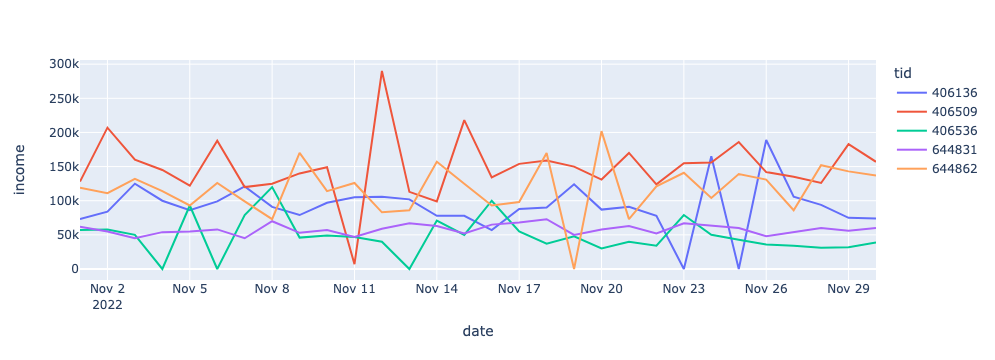

In [111]:
df = X_val.copy()
df['income'] = y_val
df['pred'] = pred
px.line(df[df['tid'].isin(good_tids)], x='date', y='income', color='tid')

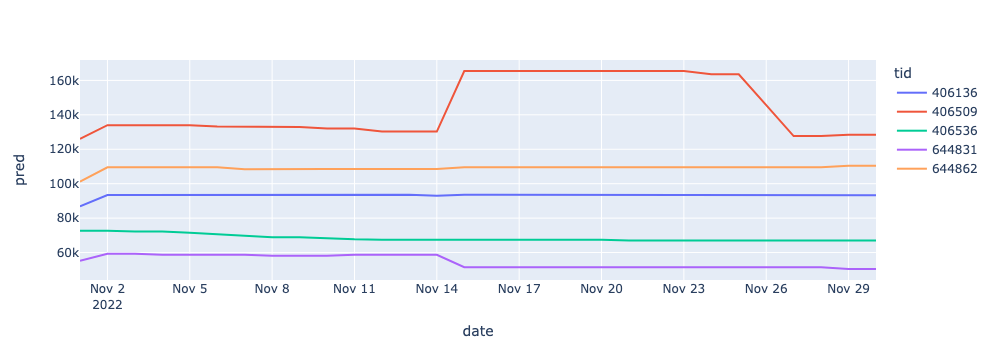

In [112]:
df = X_val.copy()
df['income'] = y_val
df['pred'] = pred
px.line(df[df['tid'].isin(good_tids)], x='date', y='pred', color='tid')

## Feature Selection

In [31]:
from catboost import Pool

fi = cat_model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_cols),
                                      prettified=True)
fi.head(25)

,Feature Id,Importances
0,tid_mean_income,63.349151
1,income_lag_1,12.653216
2,income_rmean_14,6.742865
3,income_rmean_7,5.258624
4,income_lag_7,4.408683
5,income_rmean_28,3.562650
6,income_lag_56_ewm_0.9,0.788026
7,income_lag_14,0.770489
8,income_lag_56_ewm_0.7,0.534394
9,income_lag_7_ewm_0.7,0.408624


In [30]:
from catboost import Pool

fi = cat_model.get_feature_importance(Pool(X_val, y_val, cat_features=cat_cols),
                                      prettified=True)
fi.head(25)

,Feature Id,Importances
0,income_rmean_28,37.588498
1,tid_mean_income,35.135902
2,income_rmean_14,25.328119
3,income_rmean_7,0.794831
4,income_lag_56_ewm_0.9,0.274975
5,income_lag_1,0.250134
6,income_lag_7,0.215412
7,income_lag_7_ewm_0.7,0.067427
8,income_lag_56_ewm_0.7,0.066582
9,income_lag_14,0.063424
